Training ResNET152 and Ensemble of different models - Recursive Exception error
  
    Exception: It's not possible to apply those transforms to your dataset:
    maximum recursion depth exceeded while calling a Python object 

This file is only for the error note. Kindly do not try this

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# cheking the number of cored this system has.
!cat /proc/cpuinfo | grep "cpu cores" | uniq

cpu cores	: 2


In [ ]:
# GPU info
!nvidia-smi

Wed May 12 13:49:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    35W / 250W |   2269MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Amount of system RAM available to be used.
from psutil import virtual_memory
ram_gb = virtual_memory().total / (1024 * 1024 * 1024)   
print('Your runtime has {:.1f} gigabyte of availabe\n'.format(ram_gb))

Your runtime has 25.5 gigabyte of availabe



In [ ]:
import sys
print(sys.getrecursionlimit())
sys.setrecursionlimit(10000)

1000


In [ ]:
print(sys.getrecursionlimit())

10000


In [ ]:

# !pip install git+https://github.com/fastai/fastai.git
!pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate

In [ ]:
path = untar_data(URLs.FOOD)

In [ ]:
train_path = '/root/.fastai/data/food-101/train.txt'
test_path = '/root/.fastai/data/food-101/test.txt'

def filelist2df(path):
    df = pd.read_csv(path, delimiter='/', header=None, names=['label', 'name'])
    df['name'] =  df['label'].astype(str) + "/" + df['name'].astype(str) + ".jpg"
    return df

train_df = filelist2df(train_path)
test_df = filelist2df(test_path)

ds_tfms = ([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-40, 40)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.4), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.35, 0.65)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.7, 1.43)}, p=0.75, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmCoord (jitter), kwargs={'magnitude': (-0.01, 0.01)}, p=0.3, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmCoord (skew), kwargs={'direction': (0, 7), 'magnitude': (0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmAffine (squish), kwargs={'scale': (0.42, 2.4), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True)], 
           [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)])

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(40)

In [ ]:
def evaluate_performance(y_true, y_predict):
  import sklearn.metrics as metrics
  print(f"{metrics.classification_report(y_true.items, y_predict)}\n")

  import matplotlib.pyplot as plt
  from sklearn.metrics import confusion_matrix

  cm1 = confusion_matrix(y_true.items,y_predict)
  print(cm1)

  print("No.of validation set samples predicted correctly ",sum(cm1.diagonal()))
  print("No.of misclassified samples ", len(y_predict)-sum(cm1.diagonal()))

  #Calculating the True Occurences
  true_occ= []
  for i in range(len(cm1)):
    true_occ.append(sum(cm1[:,i]))

  #Calculating the recall for all the categories
  dia = cm1.diagonal()
  prediction_prob=[]
  for i in range(len(cm1)):
    tmp_prob = dia[i]/true_occ[i]
    prediction_prob.append(tmp_prob)

  incorrect_class = prediction_prob.index(min(prediction_prob))
  correct_class = prediction_prob.index(max(prediction_prob))
  print("Food category with more no.of correct predictions ",y_true.classes[correct_class] )
  print("Food category with min no.of correct predictions ",y_true.classes[incorrect_class] )

In [ ]:
#checking if the valid items are the same
def crossverify(data_valid_y):
  oop = pd.DataFrame(data_valid_y.items)
  count_valid = oop.value_counts()
  cat_vd = []
  count_vd=[]
  for i in range(101):
    cat_vd.append(i)
    count_vd.append(count_valid[i])
  dict_shift = dict(zip(cat_vd, count_vd))
  count_id = np.array(count_vd)
  if (count_id[0] == 149 and count_id[1]==138 and count_id[2]==150 and count_id[3]==154):
    return True
  else:
    return False

**ResNET152** 

In [ ]:
bs_res = 16
arch = models.resnet152
img_size_res = 224

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(40)

In [ ]:
data = (ImageList.from_df(df=train_df, path=path/'images', cols=1)
        .split_by_rand_pct(0.2)
        .label_from_df(cols=0)
        .transform(ds_tfms, size=img_size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

Exception: ignored

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 2.29E-03


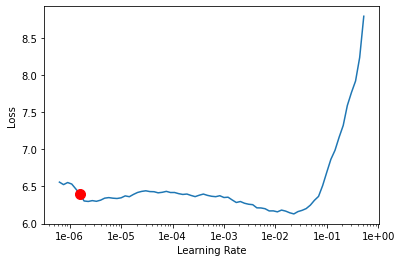

In [ ]:
top_5 = partial(top_k_accuracy, k=5)
learn = cnn_learner(data, arch, metrics=[accuracy, top_5], callback_fns=ShowGraph).to_fp16()

learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.381126,1.640651,0.579076,0.832145,14:07
1,1.852433,1.254783,0.670165,0.888383,14:10
2,1.687498,1.130478,0.700924,0.901122,14:06


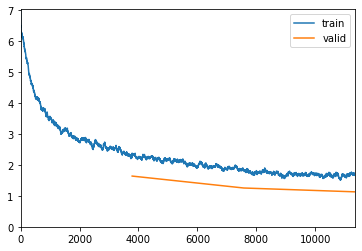

In [ ]:
lr = 3e-3
learn.fit_one_cycle(3, max_lr=slice(lr))
learn.save('/content/drive/MyDrive/food-ResNET101-train-e3')

In [ ]:
top_5 = partial(top_k_accuracy, k=5)
arch = models.resnet152
learn = cnn_learner(data, arch, metrics=[accuracy, top_5], callback_fns=ShowGraph).to_fp16()
learn.load('/content/drive/MyDrive/food-ResNET101-train-e3')

start= time.time()
Y_valid_predict = []
for img in data.valid_dl.x:
    tmp_predict = learn.predict(img)
    Y_valid_predict.append(tmp_predict[1])
end = time.time()
print({end - start})

{738.6841576099396}


In [ ]:
evaluate_performance(data.valid_dl.y,Y_valid_predict)

              precision    recall  f1-score   support

           0       0.01      0.01      0.01       149
           1       0.01      0.01      0.01       138
           2       0.01      0.01      0.01       150
           3       0.01      0.01      0.01       154
           4       0.02      0.02      0.02       141
           5       0.00      0.00      0.00       159
           6       0.00      0.00      0.00       133
           7       0.00      0.01      0.01       136
           8       0.02      0.02      0.02       164
           9       0.01      0.01      0.01       136
          10       0.02      0.01      0.01       143
          11       0.01      0.01      0.01       145
          12       0.00      0.00      0.00       157
          13       0.00      0.00      0.00       148
          14       0.01      0.01      0.01       149
          15       0.01      0.01      0.01       148
          16       0.01      0.01      0.01       167
          17       0.00    

In [ ]:
# learn.validate(test_data.train_dl)
# y_preds = learn.get_preds(ds_type= test_data.train_dl)

# arch = models.resnet152
# test_data = (ImageList.from_df(df=test_df, path=path/'images', cols=1)
#             .split_none()
#             .label_from_df(cols=0)
#             .transform(size=224)
#             .databunch(bs=16)
#             .normalize(imagenet_stats))


# top_5 = partial(top_k_accuracy, k=5)
# learn = cnn_learner(test_data, arch, metrics=[accuracy, top_5]).to_fp16()
# learn.load('/content/models/food-ResNET101-train-e3')

# log_preds, y = learn.TTA(ds_type=test_data.train_dl)
# # predIdxs = np.argmax(log_preds.numpy(), axis=1)
# accuracy(log_preds, y)

**EfficientNetB0**

In [ ]:
#EfficientNet0 and image size 224 and see how fast it converges
bs_effb0 = 64
img_size_effb0 = 224 

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(40)

In [ ]:
data=(ImageList.from_df(df=train_df,path=path/'images',cols=1)
      .split_by_rand_pct(0.2)
      .label_from_df(cols=0)
      .transform(ds_tfms,size=img_size_effb0)
      .databunch(bs=bs_effb0)
      .normalize(imagenet_stats))

In [ ]:
pip install --upgrade efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=5a6741d3b59161dd0752be2f647866083cb1a605902f7417206a83630ba295b5
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [ ]:
#Importing the Efficient net from pytorch : Original paper implemented in Keras (tpu)
from efficientnet_pytorch import EfficientNet

In [ ]:
#Loading the pretrained efficientNetB0
model = EfficientNet.from_pretrained("efficientnet-b0")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [ ]:
top_5 = partial(top_k_accuracy,k=5)
learneffb0=Learner(data,model,metrics=[accuracy,top_5], callback_fns=ShowGraph).to_fp16() 
#by default float 32 training in 16 bits..takes only half the size. 
learneffb0.split(lambda m:(model._conv_head,)) #This helps to break the network in three parts and train with different learning rates 

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-03
Min loss divided by 10: 1.00E-02


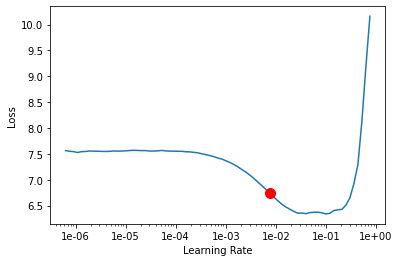

In [ ]:
learneffb0.lr_find()
learneffb0.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.940203,2.023063,0.564950,0.817690,10:12
1,1.642788,1.301134,0.672409,0.883234,10:21
2,1.169452,0.914325,0.762574,0.928779,10:15
3,0.905310,0.799026,0.792739,0.939076,10:14


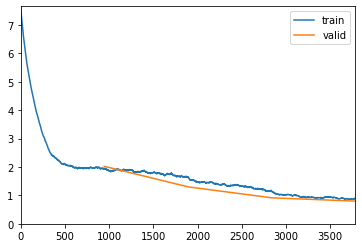

In [ ]:
lr = 9e-3
learneffb0.fit_one_cycle(4,max_lr=slice(lr))
learneffb0.save('/content/drive/MyDrive/food-effNetb0101-train-e4')

In [ ]:
start= time.time()
Y_valid_predict_eff = []
for img in data.valid_dl.x:
    tmp_predict = learneffb0.predict(img)
    Y_valid_predict_eff.append(tmp_predict[1])
end = time.time()
print('Time taken to predict for EfficientNet  :',{end - start})

import sklearn.metrics as metrics
print(f"{metrics.classification_report(data.valid_dl.y.items, Y_valid_predict_eff)}\n")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(data.valid_dl.y.items,Y_valid_predict_eff)
print(cm)

print("No.of validation set samples predicted correctly ",sum(cm.diagonal()))
print("No.of misclassified samples ", len(Y_valid_predict_eff)-sum(cm.diagonal()))

#Calculating the True Occurences
true_occ= []
for i in range(len(cm)):
  true_occ.append(sum(cm[:,i]))

#Calculating the recall for all the categories
dia = cm.diagonal()
prediction_prob=[]
for i in range(len(cm)):
  tmp_prob = dia[i]/true_occ[i]
  prediction_prob.append(tmp_prob)

incorrect_class = prediction_prob.index(min(prediction_prob))
correct_class = prediction_prob.index(max(prediction_prob))
print("Food category with more no.of correct predictions ",data.valid_dl.y.classes[correct_class] )
print("Food category with min no.of correct predictions ",data.valid_dl.y.classes[incorrect_class] )


Time taken to predict for EfficientNet  : {362.94547939300537}
              precision    recall  f1-score   support

           0       0.67      0.58      0.62       149
           1       0.73      0.76      0.75       138
           2       0.86      0.79      0.83       150
           3       0.88      0.81      0.84       154
           4       0.77      0.77      0.77       141
           5       0.74      0.74      0.74       159
           6       0.82      0.88      0.85       133
           7       0.84      0.90      0.87       136
           8       0.67      0.65      0.66       164
           9       0.81      0.70      0.75       136
          10       0.74      0.73      0.74       143
          11       0.81      0.83      0.82       145
          12       0.86      0.83      0.85       157
          13       0.84      0.84      0.84       148
          14       0.82      0.68      0.74       149
          15       0.63      0.69      0.66       148
          16      

In [ ]:
data.train_dl.y

array([  0,   0,   0,   0, ..., 100, 100, 100, 100])

**EfficientNetB4**

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/checkpoints/efficientnet-b4-6ed6700e.pth



Loaded pretrained weights for efficientnet-b4


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-03
Min loss divided by 10: 2.75E-03


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.783179,1.398044,0.663168,0.881650,59:36
1,1.222181,0.815812,0.790891,0.940990,59:33
2,0.810390,0.597301,0.848845,0.962046,59:30


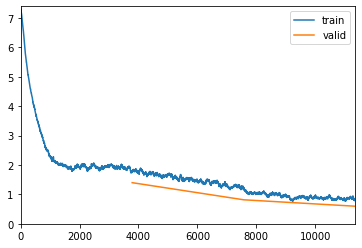

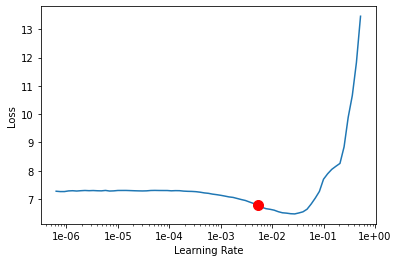

In [ ]:
#EfficientNet4 and image size 512 and see how fast it converges
bs_effb4 = 16
img_size_effb4 = 512 

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(40)

data=(ImageList.from_df(df=train_df,path=path/'images',cols=1)
      .split_by_rand_pct(0.2)
      .label_from_df(cols=0)
      .transform(ds_tfms,size=img_size_effb4)
      .databunch(bs=bs_effb4)
      .normalize(imagenet_stats))

if crossverify(data.valid_dl.y):	  
  model = EfficientNet.from_pretrained("efficientnet-b4")	  

  top_5 = partial(top_k_accuracy, k=5)

  learneffb4 = Learner(data, model, metrics=[accuracy, top_5], callback_fns=ShowGraph).to_fp16()
  learneffb4.split( lambda m: (model._conv_head,) )

  learneffb4.lr_find()
  learneffb4.recorder.plot(suggestion=True)

  lr = 4e-3
  learneffb4.fit_one_cycle(3, max_lr=slice(lr))
  learneffb4.save('/content/drive/MyDrive/food-effNetb4101-train-e3')
else:
  print("Data Mismatch")

In [ ]:
start= time.time()
Y_valid_predict_eff4 = []
for img in data.valid_dl.x:
    tmp_predict = learneffb4.predict(img)
    Y_valid_predict_eff4.append(tmp_predict[1])
end = time.time()
print('Time taken to predict for EfficientNetb4  :',{end - start})

import sklearn.metrics as metrics
print(f"{metrics.classification_report(data.valid_dl.y.items, Y_valid_predict_eff4)}\n")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(data.valid_dl.y.items,Y_valid_predict_eff4)
print(cm1)

print("No.of validation set samples predicted correctly ",sum(cm1.diagonal()))
print("No.of misclassified samples ", len(Y_valid_predict_eff4)-sum(cm1.diagonal()))

#Calculating the True Occurences
true_occ= []
for i in range(len(cm1)):
  true_occ.append(sum(cm1[:,i]))

#Calculating the recall for all the categories
dia = cm1.diagonal()
prediction_prob=[]
for i in range(len(cm1)):
  tmp_prob = dia[i]/true_occ[i]
  prediction_prob.append(tmp_prob)

incorrect_class = prediction_prob.index(min(prediction_prob))
correct_class = prediction_prob.index(max(prediction_prob))
print("Food category with more no.of correct predictions using EfficientNetB4",data.train_dl.y.classes[correct_class] )
print("Food category with min no.of correct predictions using EfficientNetB4 ",data.train_dl.y.classes[incorrect_class] )

Time taken to predict for EfficientNetb4  : {601.5534358024597}
              precision    recall  f1-score   support

           0       0.80      0.62      0.70       158
           1       0.84      0.86      0.85       138
           2       0.87      0.94      0.90       143
           3       0.96      0.89      0.93       160
           4       0.84      0.86      0.85       145
           5       0.87      0.84      0.85       168
           6       0.88      0.92      0.90       154
           7       0.90      0.95      0.92       155
           8       0.73      0.69      0.71       168
           9       0.72      0.80      0.76       152
          10       0.87      0.80      0.84       148
          11       0.93      0.91      0.92       150
          12       0.92      0.87      0.89       156
          13       0.89      0.89      0.89       149
          14       0.89      0.76      0.82       146
          15       0.77      0.78      0.77       148
          16     

In [ ]:
evaluate_performance()

**Ensemble of ResNET,EfficientNetB0 and EfficientNetB4**

In [ ]:
def majority(a,b,c):
  if a==b:
    return c
  elif b ==c:
    return c
  elif a==c:
    return c
  else:
    return c

In [ ]:
y_predict_ensemble=[]
for i in range(len(Y_valid_predict_eff4)):
  y_predict_ensemble.append(majority(Y_valid_predict[i],Y_valid_predict_eff[i],Y_valid_predict_eff4[i]))

In [ ]:
import sklearn.metrics as metrics
print(f"{metrics.classification_report(data.valid_dl.y.items, y_predict_ensemble)}\n")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm_en = confusion_matrix(data.valid_dl.y.items,y_predict_ensemble)
print(cm_en)

print("No.of validation set samples predicted correctly ",sum(cm_en.diagonal()))
print("No.of misclassified samples ", len(y_predict_ensemble)-sum(cm_en.diagonal()))

#Calculating the True Occurences
true_occ= []
for i in range(len(cm_en)):
  true_occ.append(sum(cm_en[:,i]))

#Calculating the recall for all the categories
dia = cm_en.diagonal()
prediction_prob=[]
for i in range(len(cm_en)):
  tmp_prob = dia[i]/true_occ[i]
  prediction_prob.append(tmp_prob)

incorrect_class = prediction_prob.index(min(prediction_prob))
correct_class = prediction_prob.index(max(prediction_prob))
print("Food category with more no.of correct predictions using Ensemble model",data.train_dl.y.classes[correct_class] )
print("Food category with min no.of correct predictions using Ensemble model ",data.train_dl.y.classes[incorrect_class] )

In [ ]:
evaluate_performance(data.valid_dl.y, Y_valid_predict_eff4)

              precision    recall  f1-score   support

           0       0.80      0.62      0.70       158
           1       0.84      0.86      0.85       138
           2       0.87      0.94      0.90       143
           3       0.96      0.89      0.93       160
           4       0.84      0.86      0.85       145
           5       0.87      0.84      0.85       168
           6       0.88      0.92      0.90       154
           7       0.90      0.95      0.92       155
           8       0.73      0.69      0.71       168
           9       0.72      0.80      0.76       152
          10       0.87      0.80      0.84       148
          11       0.93      0.91      0.92       150
          12       0.92      0.87      0.89       156
          13       0.89      0.89      0.89       149
          14       0.89      0.76      0.82       146
          15       0.77      0.78      0.77       148
          16       0.89      0.93      0.91       136
          17       0.75    